## MOSAIKS feature extraction

This tutorial demonstrates the **MOSAIKS** method for extracting _feature vectors_ from satellite imagery patches for use in downstream modeling tasks. It will show:
- How to extract 1km$^2$ patches of Sentinel 2 multispectral imagery for a list of latitude, longitude points
- How to extract summary features from each of these imagery patches
- How to use the summary features in a linear model of the population density at each point

### Background

Consider the case where you have a dataset of latitude and longitude points assosciated with some dependent variable (for example: population density, weather, housing prices, biodiversity) and, potentially, other independent variables. You would like to model the dependent variable as a function of the independent variables, but instead of including latitude and longitude directly in this model, you would like to include some high dimensional representation of what the Earth looks like at that point (that hopefully explains some of the variance in the dependent variable!). From the computer vision literature, there are various [representation learning techniques](https://en.wikipedia.org/wiki/Feature_learning) that can be used to do this, i.e. extract _features vectors_ from imagery. This notebook gives an implementation of the technique described in [Rolf et al. 2021](https://www.nature.com/articles/s41467-021-24638-z), "A generalizable and accessible approach to machine learning with global satellite imagery" called Multi-task Observation using Satellite Imagery & Kitchen Sinks (**MOSAIKS**). For more information about **MOSAIKS** see the [project's webpage](http://www.globalpolicy.science/mosaiks).


**Notes**:
- This example uses [Sentinel-2 Level-2A data](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a). The techniques used here apply equally well to other remote-sensing datasets.
- If you're running this on the [Planetary Computer Hub](http://planetarycomputer.microsoft.com/compute), make sure to choose the **GPU - PyTorch** profile when presented with the form to choose your environment.

In [1]:
!pip install -q git+https://github.com/geopandas/dask-geopandas

In [2]:
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from dask.distributed import Client


warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="sklearn")

import pystac_client
import planetary_computer as pc

## Create grid and sample points to featurize

In [3]:
adm_level = "adm1"

geodetic_epsg = 'EPSG:4326'
# projected_epsg = 'EPSG:26332'  # Nigeria 'EPSG:26332',  Zambia 'EPSG:20935',   Tanzania EPSG:21037
projected_epsg = 'EPSG:20935' 

africa = geopandas.read_file('data/africa_adm0.geojson')
# country = africa[africa.adm0_a3 == 'NGA']
country = africa[africa.adm0_a3 == 'ZMB']

country_prj = country.to_crs(projected_epsg)

xmin, ymin, xmax, ymax = country_prj.total_bounds
cell_size = 2000
xs = list(np.arange(xmin, xmax + cell_size, cell_size))
ys = list(np.arange(ymin, ymax + cell_size, cell_size))
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = shapely.geometry.Polygon(ring).centroid
    return cell
cells = []
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        cells.append(cell)
        
grid = geopandas.GeoDataFrame({'geometry': cells}, crs = projected_epsg)
grid['lon'] = grid.geometry.x
grid['lat'] = grid.geometry.y
grid['x'] = grid.groupby(['lon']).ngroup() + 1
grid['y'] = grid.groupby(['lat']).ngroup() + 1
grid['includepoint'] = (grid.y + grid.x) % 2 == 0 
grid = grid[grid.includepoint]

gdf = grid[grid.within(country_prj.unary_union)]
gdf = gdf.to_crs(geodetic_epsg)
gdf['lon'] = gdf.geometry.x
gdf['lat'] = gdf.geometry.y
gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
gdf.shape
# points = pd.DataFrame(gdf)
# len(points)

(94184, 3)

First we define the pytorch model that we will use to extract the features and a helper method. The **MOSAIKS** methodology describes several ways to do this and we use the simplest.

In [4]:
def featurize(input_img, model, device):
    """Helper method for running an image patch through the model.

    Args:
        input_img (np.ndarray): Image in (C x H x W) format with a dtype of uint8.
        model (torch.nn.Module): Feature extractor network
    """
    assert len(input_img.shape) == 3
    input_img = torch.from_numpy(input_img / 255.0).float()
    input_img = input_img.to(device)
    with torch.no_grad():
        feats = model(input_img.unsqueeze(0)).cpu().numpy()
    return feats


class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""

    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3):
        super(RCF, self).__init__()

        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, -1.0)

    def forward(self, x):
        x1a = F.relu(self.conv1(x), inplace=True)
        x1b = F.relu(-self.conv1(x), inplace=True)

        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()

        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)

Next, we initialize the model and pytorch components

In [5]:
num_features = 2048

device = torch.device("cuda")
model = RCF(num_features).eval().to(device)

### Extract features from the imagery around each point

We need to find a suitable Sentinel 2 scene for each point. As usual, we'll use `pystac-client` to search for items matching some conditions, but we don't just want do make a `.search()` call for each of the 67,968 remaining points. Each HTTP request is relatively slow. Instead, we will *batch* or points and search *in parallel*.

We need to be a bit careful with how we batch up our points though. Since a single Sentinel 2 scene will cover many points, we want to make sure that points which are spatially close together end up in the same batch. In short, we need to spatially partition the dataset. This is implemented in `dask-geopandas`.

So the overall workflow will be

1. Find an appropriate STAC item for each point (in parallel, using the spatially partitioned dataset)
2. Feed the points and STAC items to a custom Dataset that can read imagery given a point and the URL of a overlapping S2 scene
3. Use a custom Dataloader, which uses our Dataset, to feed our model imagery and save the corresponding features

In [6]:
NPARTITIONS = 250

ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd")

dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)

We'll write a helper function that 

In [7]:
year = 2021
def query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull)

    search_start = f"{year}-01-01"
    search_end = f"{year}-12-31"
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": 15}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }

    index = []

    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = geopandas.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)

In [8]:
%%time

with Client(n_workers=16) as client:
    print(client.dashboard_link)
    meta = dgdf._meta.assign(stac_item=[])
    df2 = dgdf.map_partitions(query, meta=meta).compute()

/user/cullen.molitor@gmail.com/proxy/8787/status
CPU times: user 5.34 s, sys: 3.65 s, total: 8.99 s
Wall time: 57.2 s


In [9]:
df3 = df2.dropna(subset=["stac_item"])

matching_urls = [
    pc.sign(item["assets"]["visual"]["href"]) for item in df3.stac_item.tolist()
]

points = df3[["lon", "lat"]].to_numpy()

In [10]:
df3.shape

(94184, 5)

In [11]:
points.shape

(94184, 2)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, points, fns, buffer=500):
        self.points = points
        self.fns = fns
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        fn = self.fns[idx]

        if fn is None:
            return None
        else:
            point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))

            with rasterio.Env():
                with rasterio.open(fn, "r") as f:
                    point_geom = rasterio.warp.transform_geom(
                        "epsg:4326", f.crs.to_string(), point_geom
                    )
                    point_shape = shapely.geometry.shape(point_geom)
                    mask_shape = point_shape.buffer(self.buffer).envelope
                    mask_geom = shapely.geometry.mapping(mask_shape)
                    try:
                        out_image, out_transform = rasterio.mask.mask(
                            f, [mask_geom], crop=True
                        )
                    except ValueError as e:
                        if "Input shapes do not overlap raster." in str(e):
                            return None

            out_image = out_image / 255.0
            out_image = torch.from_numpy(out_image).float()
            return out_image

In [13]:
dataset = CustomDataset(points, matching_urls)

dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=os.cpu_count(),
    collate_fn=lambda x: x,
    pin_memory=False,
)

In [14]:
x_all = np.zeros((points.shape[0], num_features), dtype=float)
features = pd.DataFrame()
features['lon'] = 0
features['lat'] = 0
features['year'] = year

In [15]:
features

,lon,lat,year


In [16]:
tic = time.time()
i = 0
for images in dataloader:
    for image in images:

        if image is not None:
            # A full image should be ~101x101 pixels (i.e. ~1km^2 at a 10m/px spatial
            # resolution), however we can receive smaller images if an input point
            # happens to be at the edge of a S2 scene (a literal edge case). To deal
            # with these (edge) cases we crudely drop all images where the spatial
            # dimensions aren't both greater than 20 pixels.
            if image.shape[1] >= 20 and image.shape[2] >= 20:
                image = image.to(device)
                with torch.no_grad():
                    feats = model(image.unsqueeze(0)).cpu().numpy()

                x_all[i] = feats
                # features.iloc[i] = x_all
                features.loc[i, 'lon'] = points[i][0]
                features.loc[i, 'lat'] = points[i][1]
                features.loc[i, 'year'] = year
            else:
                # this happens if the point is close to the edge of a scene
                # (one or both of the spatial dimensions of the image are very small)
                pass
        else:
            pass  # this happens if we do not find a S2 scene for some point

        if i % 5000 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()
        i += 1

0/94184 -- 0.00% -- 1.38 seconds
5000/94184 -- 5.31% -- 41.14 seconds
10000/94184 -- 10.62% -- 42.99 seconds
20000/94184 -- 21.24% -- 42.63 seconds
25000/94184 -- 26.54% -- 43.93 seconds
30000/94184 -- 31.85% -- 43.30 seconds
35000/94184 -- 37.16% -- 43.18 seconds
40000/94184 -- 42.47% -- 37.60 seconds
45000/94184 -- 47.78% -- 52.81 seconds
50000/94184 -- 53.09% -- 38.98 seconds
55000/94184 -- 58.40% -- 39.30 seconds
60000/94184 -- 63.71% -- 37.88 seconds
65000/94184 -- 69.01% -- 35.21 seconds
70000/94184 -- 74.32% -- 39.98 seconds
75000/94184 -- 79.63% -- 37.79 seconds
80000/94184 -- 84.94% -- 39.82 seconds
85000/94184 -- 90.25% -- 42.27 seconds
90000/94184 -- 95.56% -- 41.18 seconds


In [17]:
features_df = pd.DataFrame(x_all)
features_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.643098,0.000006,0.174368,0.0,0.001117,0.000019,0.0,0.001271,0.000294,...,0.000000,1.457583,2.504756,0.324721,1.178519,6.206095,2.855138,3.938239,3.057802,4.586231
1,0.0,0.221679,0.000000,0.034618,0.0,0.000017,0.000000,0.0,0.000000,0.004799,...,0.000343,1.402765,1.908961,0.348535,1.079088,4.224564,2.369996,2.786621,2.110905,3.205053
2,0.0,0.632205,0.000000,0.126951,0.0,0.001503,0.000000,0.0,0.000000,0.000000,...,0.001073,1.506072,2.514337,0.257543,1.172570,6.159379,2.907270,3.912390,3.024115,4.581631
3,0.0,0.109239,0.000000,0.008503,0.0,0.000000,0.000000,0.0,0.000000,0.000202,...,0.002583,1.313100,1.912462,0.461452,1.058419,4.026430,2.224996,2.638197,2.122282,3.075799
4,0.0,0.031319,0.000000,0.000423,0.0,0.000006,0.000000,0.0,0.000000,0.000000,...,0.000000,1.344101,1.915753,0.374211,1.051026,4.011394,2.272540,2.594846,2.015957,3.057971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94179,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.301161,1.058945,1.330068,0.804308,0.955276,1.755701,1.391527,1.273554,1.206986,1.508865
94180,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.248353,1.068168,1.348213,0.781300,0.952029,1.800547,1.424169,1.289498,1.213118,1.538932
94181,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.183020,1.078042,1.372921,0.756514,0.948768,1.862977,1.462432,1.313709,1.225101,1.580962
94182,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.191174,1.075257,1.372328,0.761202,0.948916,1.856543,1.456929,1.309967,1.225358,1.577071


In [18]:
features_df_2 = features_df.join(features)
features_df_2.columns = features_df_2.columns.astype(str)

In [19]:
file_name = f'data/features_{year}.feather'
features_df_2.to_feather(file_name)

In [20]:
# import seaborn as sns
# plt.figure(figsize = (15,10))
# sns.heatmap(features_df, annot=False, cmap = 'viridis')

In [21]:
features_df_2['total'] = features_df_2.iloc[:, 0:-4].mean(axis=1)

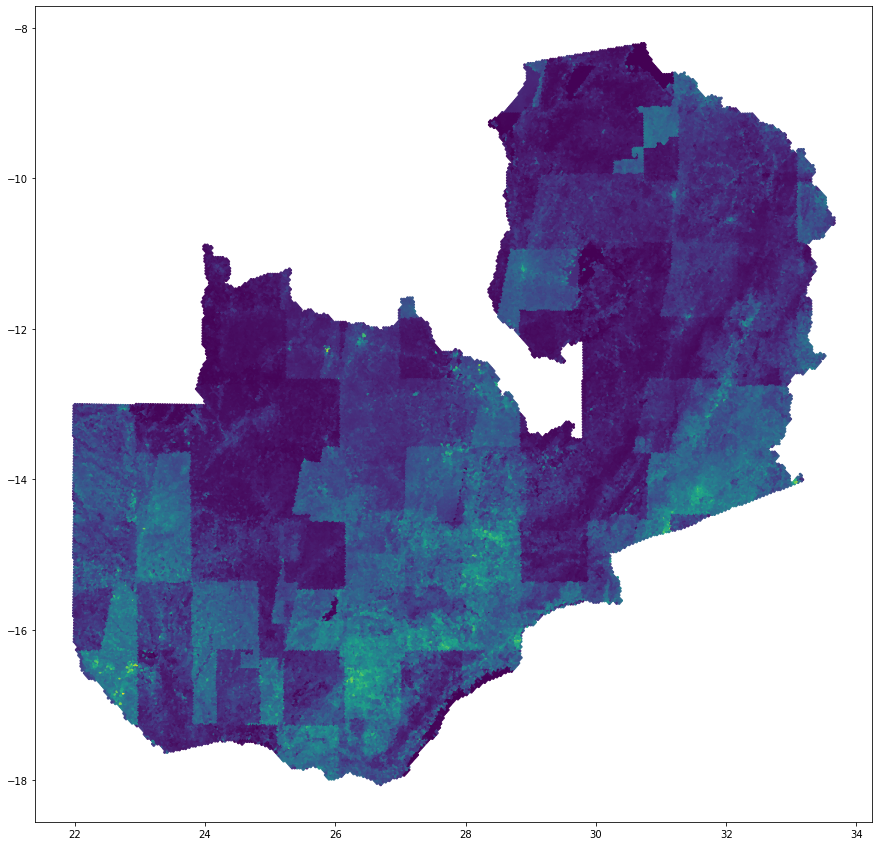

In [22]:
plt.figure(figsize = (15,15))
plt.scatter(features_df_2.lon, features_df_2.lat, c = features_df_2.total, cmap = 'viridis', s = 4, alpha = 1)